# CSCI 4155/6505 - A3 (Part 1) - To be submitted individually

**[Total of 4 points for Part 1]**

For Part 1 of this assignment, you will be modifying the functionality of some base code that implements a convolutional network in PyTorch. Follow along this notebook in Google Colab, running each code block as you go, and insert answers where appropriate.
(Optional note: this assignment builds directly on last week's lab where you modified parts of the PyTorch tutorials!)



In [0]:
%matplotlib inline

In [0]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms

# For plotting
import matplotlib.pyplot as plt

First, we have to load the MNIST dataset. Try running the code block below, and if it executes successfully, you should see a printout saying that there are 60,000 training examples and 10,000 test examples. A folder titled "mnist_data" will appear in your left sidebar if you click on the folder icon.

In [5]:
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

classes = [i for i in range(10)]

print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
Training examples:  60000
Test examples:  10000


For now we will assume that we are using the MNIST dataset. I want to call a single function that encapsulates all parts of the process: initializing the network, training, and testing. Passing to this function as arguments, I want to be able to control some basic functionality of the learning process:

*   Number of epochs (repetitions of the entire training data)
*   Batch size (how many training examples to average over per gradient update)

The function call will look like:

```
losses, train_acc, test_acc = eval_net(epochs, batch_size)
```

*   `losses` will be a list of all the losses I saw during training: one for every update.
*   `train_acc` will be a single scalar: the accuracy on the training data after training is finished.
*   `test_acc` will be a single scalar: the accuracy on the test data after training is finished

Below is the implementation of `eval_net()`.

(Optional note: If the following code is confusing, please note that this is exactly the same as what you already went through step-by-step in last week's lab, so you may need to review that first.)

In [0]:
def eval_net(epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

Now we can try out our implementation!

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8595666666666667
Test accuracy:  0.8625


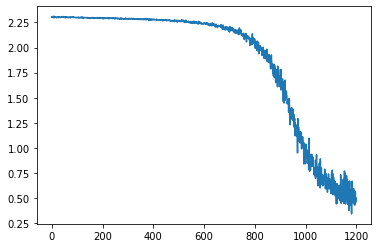

In [0]:
losses, train_acc, test_acc = eval_net(epochs=2, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()

# Questions

For the following questions, you will mostly be copying and pasting the implementation of `eval_net()` and modifying a few things.


---
---
---


a) **[1 point]** You will implement a modification called `eval_net_a()`. Since we are following the implementation in `eval_net()`, assume that there are always 2 convolutional layers, and 2 fully connected hidden layers (the layer of size 10 is the output). We want to control the number of filters and the size of the hidden layers. As arguments, we will pass the epoch and batch_size as before, but also pass a list containing 4 elements: 

*   The number of filters in convolutional layer 1
*   The number of filters in convolutional layer 2
*   The number of hidden nodes in fully connected layer 1
*   The number of hidden nodes in fully connected layer 2

```
num_params = [num_filters1, num_filters2, num_hidden1, num_hidden2]
```

In [0]:
def eval_net_a(epochs, batch_size, num_params):
  # Insert your answer here
  num_filters1 = num_params[0]
  num_filters2 = num_params[1]
  num_hidden1 = num_params[2]
  num_hidden2 = num_params[3]
  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, num_filters1, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(num_filters1, num_filters2, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(num_filters2 * 5 * 5, num_hidden1) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(num_hidden1, num_hidden2)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(num_hidden2, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      
      x = x.view(-1, num_filters2 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8912833333333333
Test accuracy:  0.8995


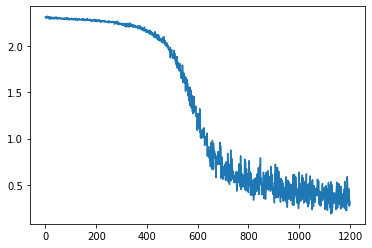

In [0]:
# We will call your answer like this:
losses, train_acc, test_acc = eval_net_a(epochs=2, batch_size=100, num_params=[6, 16, 120, 84])
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()

---
---
---

b) **[1 point]** You will implement a modification called `eval_net_b()`. **Remove the second convolutional layer from `eval_net()`.** Now there should only be 1 convolutional layer, followed by 1 pooling layer, and 2 fully connected hidden layers. The convolutional filters are currently 3x3 and the pooling is currently 2x2. We will keep these square, but we want to control the size of the filters and the size of the pooling layer. We will add a new argument that controls these:

```
sizes = [filter_size, pooling_size]
```

**Be warned:** by modifying the filter sizes, you will also have to modify the total number of inputs into the first hidden layer. It was hard-coded at `16*5*5`, because we figured out that the images were reduced to 5x5 images after the convolution and pooling, but this will no longer be true. **Hint: use `x.size()` to get the proper dimensions.**

In [0]:
def eval_net_b(epochs, batch_size, sizes):
  # Insert your answer here

  filter_size = sizes[0]
  pooling_size = sizes[1]

  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, filter_size)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(pooling_size, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      temp = torch.rand(1, 1, 28, 28)
      temp = self.pool(F.relu(self.conv1(temp)))
      input_size = 1
      for i in temp.size():
        input_size = input_size * i
      self.fc1 = nn.Linear(input_size, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      temp = torch.rand(1, 1, 28, 28)
      temp = self.pool(F.relu(self.conv1(temp)))
      size = 1
      for i in temp.size():
        size = size * i
      x = x.view(-1, size) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc



Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.893
Test accuracy:  0.8987


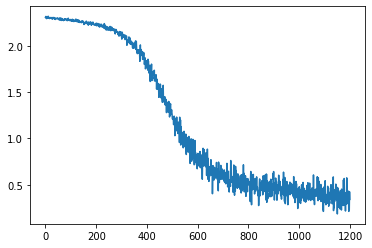

In [0]:
# We will call your answer like this:
losses, train_acc, test_acc = eval_net_b(epochs=2, batch_size=100, sizes=[3, 2])
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()

---
---
---

c) **[1 point]** You will implement a modification called `eval_net_c()`. The original `eval_net()` uses ReLU activations in the hidden layers. We should also try different activation functions. **Find a new activation function in the torch.nn.functional documentation.** They are listed under "Non-linear activation functions".

https://pytorch.org/docs/stable/nn.functional.html

Replace the ReLU activations with your new activation function. Many of these take additional arguments. Feel free to try out different values for these parameters.

**Also find a new pooling function.** These can be found at:

https://pytorch.org/docs/stable/nn.html

listed under "Pooling layers". Be sure to pick one with the "2d" suffix. Currently we are using MaxPool2d. Replace it with the pooling function that you find.

In [0]:
def eval_net_c(epochs, batch_size):
  # Insert your answer here
   ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.LPPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.selu(self.conv1(x)))
      x = self.pool(F.selu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.selu(self.fc1(x))
      x = F.selu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9271166666666667
Test accuracy:  0.9315


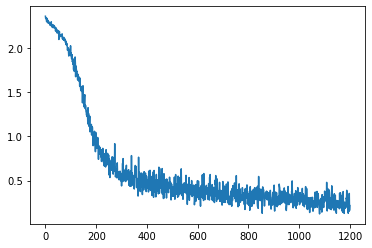

In [8]:
# We will call your answer like this:
losses, train_acc, test_acc = eval_net_c(epochs=2, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()

---
---
---

d) **[1 point]** You will implement a modification called `eval_net_d()`. During training, we use backpropagation to compute the gradient of the weights when we call:

`loss.backward()`

Then we use the gradient to update the weights in the step:

`optimizer.step()`

The exact formula used to update the weights depends on which optimizer we chose. In `eval_net()`, we are using Stochastic Gradient Descent (SGD), with momentum. There are many optimizers, some of which can be found at:

https://pytorch.org/docs/stable/optim.html

**Find a new optimization algorithm under "Algorithms" and replace the optimizer in `eval_net()` with it.** Some algorithms include Adadelta, Adagrad, Adam, and RMSProp. Some of them require additional parameters. Feel free to use the defaults, or try out different values.

In [0]:
def eval_net_d(epochs, batch_size):
  # Insert your answer here
  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9775
Test accuracy:  0.9772


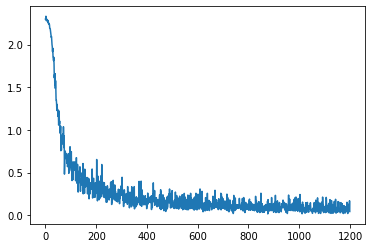

In [0]:
# We will call your answer like this:
losses, train_acc, test_acc = eval_net_d(epochs=2, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()